In [1]:
import os
import numpy as np
import seaborn as sns
import pandas as pd
import math
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor as gpr
from sklearn.gaussian_process import kernels as krnl
import scipy.stats as st
from scipy import optimize

#from multiprocessing import Pool
#from multiprocessing import cpu_count

import time

/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments w

Text(0.5, 0, 'Time (S)')

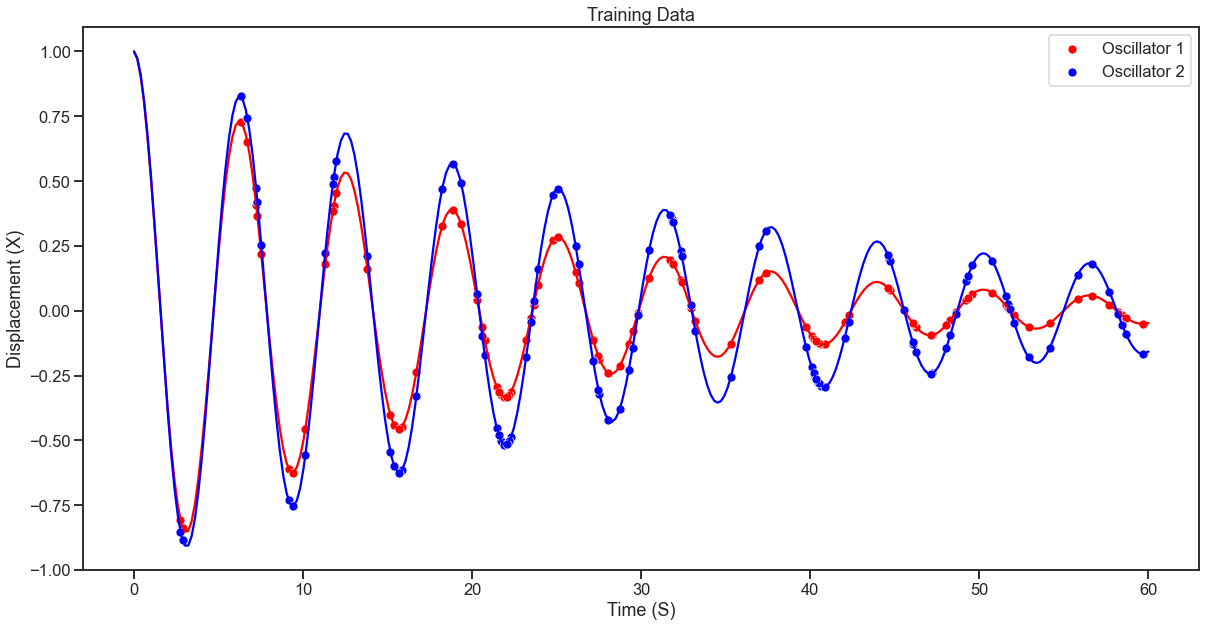

In [2]:
# Genertate Fake Data
sns.set_context('talk')
sns.color_palette("dark")
sns.set_style('ticks')
#plt.style.use("dark_background")


t_train = np.random.uniform(0,60,100).reshape(-1,1)
t_plot = np.linspace(0,60,300)

@np.vectorize
def red(t):
    f = math.exp(-0.05*t)*math.cos(t) 
    return f

@np.vectorize
def blue(t):
    f = math.exp(-0.03*t) * math.cos(t)
    return f
    
#yoda_force = np.array(yoda(t_train)).reshape(-1,1)
#luke_force = np.array(luke(t_train)).reshape(-1,1)
fig, ax = plt.subplots(figsize=(20,10))

sns.scatterplot(t_train.flatten(),red(t_train).flatten(),ax=ax,marker='o', label='Oscillator 1', color='red')
sns.lineplot(t_plot.flatten(), red(t_plot).flatten(), ax=ax , color = 'red')

sns.scatterplot(t_train.flatten(),blue(t_train).flatten(),ax=ax,marker='o', label='Oscillator 2', color='blue')
sns.lineplot(t_plot.flatten(), blue(t_plot).flatten(), ax=ax , color = 'blue')




ax.set_title('Training Data')
ax.set_ylabel('Displacement (X)')
ax.set_xlabel('Time (S)')

In [3]:
import GPy
import emukit.multi_fidelity
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
## Convert lists of arrays to ndarrays augmented with fidelity indicators
from sklearn.model_selection import train_test_split
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays
from sklearn.model_selection import KFold
#from emukit.multi_fidelity.models.non_linear_multi_fidelity_model import make_non_linear_kernels, NonLinearMultiFidelityModel
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib
n_proc=5
n_opt = 10

In [4]:
# Train GP using the above data for Yodas power
x_train = np.array(t_train).reshape(-1,1)
y_train = np.array(red(t_train)).reshape(-1,1)
print(x_train.shape)
print(y_train.shape)

kernel = GPy.kern.RBF(input_dim=1, ARD=True)
red_gp_model = GPy.models.GPRegression(x_train,y_train, kernel)
## Fit the GP model
red_gp_model.optimize_restarts(n_opt, verbose=True, parallel=True, num_processes=n_proc)
print(red_gp_model)


(100, 1)
(100, 1)
Optimization restart 1/10, f = -518.2428142026749
Optimization restart 2/10, f = -518.242828042076
Optimization restart 3/10, f = -518.2428093720841
Optimization restart 4/10, f = -518.2427986983896
Optimization restart 5/10, f = -518.242817817567
Optimization restart 6/10, f = -518.2428030580808
Optimization restart 7/10, f = -518.2427953231792
Optimization restart 8/10, f = -518.2425614178442
Optimization restart 9/10, f = -518.2428223571742
Optimization restart 10/10, f = -518.2427820912624

Name : GP regression
Objective : -518.242828042076
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  rbf.variance             |      6.625774752302685  |      +ve      |        
  rbf.lengthscale          |      3.476251104519847  |      +ve      |        
  Gaussian_noise.variance  |  4.184773614584047e-15  |      +ve      |        


In [5]:
t_test = np.linspace(0,60,300).reshape(-1,1)
red_gp_mean, red_gp_variance = red_gp_model.predict(t_test)

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will 

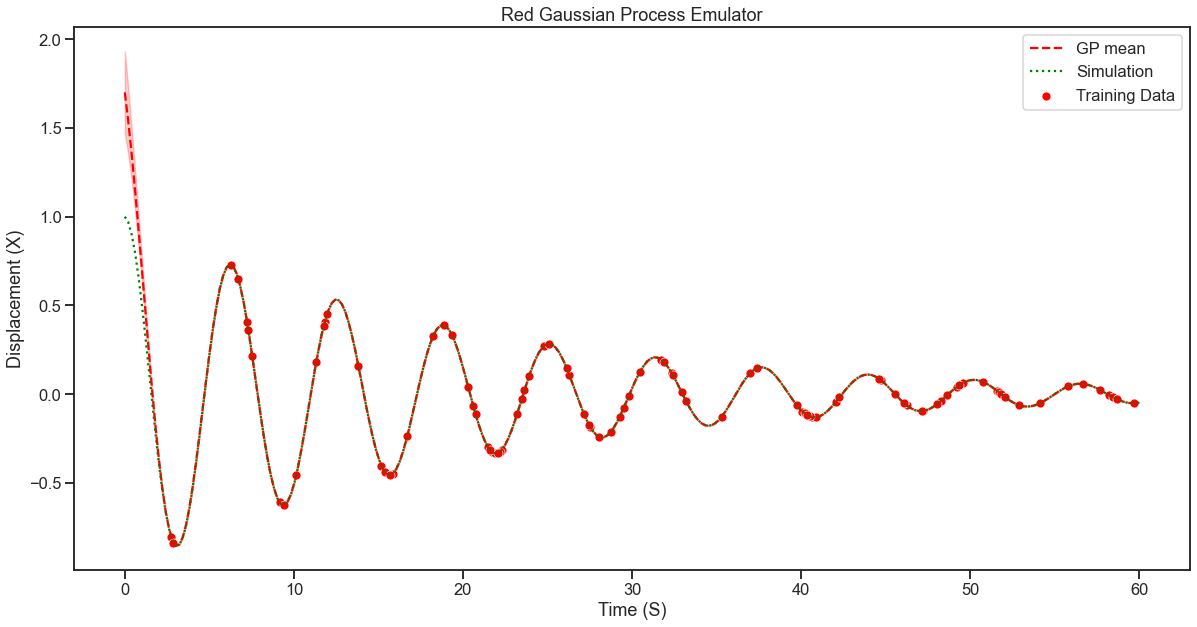

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(t_test.flatten(), red_gp_mean.flatten(), label = 'GP mean', linestyle='--', color='r', ax=ax)
sns.lineplot(t_plot.flatten(), red(t_plot).flatten(), label = 'Simulation', color='g', linestyle='dotted',ax=ax)
sns.scatterplot(t_train.flatten(),red(t_train).flatten(),ax=ax,marker='o', label='Training Data', color='red')


low = red_gp_mean-np.sqrt(red_gp_variance)
high = red_gp_mean + np.sqrt(red_gp_variance)
ax.fill_between(t_test.flatten(), low.flatten(),high.flatten(),color='r', alpha=0.2)
ax.set_title('Red Gaussian Process Emulator')
ax.set_ylabel('Displacement (X)')
ax.set_xlabel('Time (S)')
fig.savefig('red_emulator.png', dpi = 100)

In [7]:
# make a transfer learning emulator for Luke

def make_tl_emulator(n_samples):
    x_train_s = t_train
    x_train_t = t_train[0:n_samples]
    y_train_s = red(t_train)
    y_train_t = blue(x_train_t)
    
    x_test_t = np.linspace(0,60,100).reshape(-1,1)
    y_test_t = blue(x_test_t).flatten()
    
    X_train, Y_train = convert_xy_lists_to_arrays([x_train_s, x_train_t], [y_train_s, y_train_t])
    n_opt = 50
    n_proc = 10
    
    ## Construct a linear multi-fidelity model

    #kernels = [GPy.kern.RBF(17, ARD=True), GPy.kern.RBF(17, ARD=True)]
    kernels = [GPy.kern.RBF(1, ARD=True), GPy.kern.RBF(1, ARD=True)]
    lin_tl_kernel = emukit.multi_fidelity.kernels.LinearMultiFidelityKernel(kernels)
    gpy_lin_tl_model = GPyLinearMultiFidelityModel(X_train, Y_train, lin_tl_kernel, n_fidelities=2)
    
    #Set the parameters in the Source Gaussian Process
    
    rbf_l_scales = red_gp_model.rbf.lengthscale.values
    rbf_var = red_gp_model.rbf.variance.values[0]
    wn = red_gp_model.Gaussian_noise.variance.values[0]
    
    gpy_lin_tl_model.multifidelity.rbf.lengthscale.fix(value=rbf_l_scales)
    gpy_lin_tl_model.multifidelity.rbf.variance.fix(value=rbf_var)
    gpy_lin_tl_model.mixed_noise.Gaussian_noise.fix(wn)
    #gpy_lin_mf_model.mixed_noise.Gaussian_noise_1.fix(0)


    ## Wrap the model using the given 'GPyMultiOutputWrapper'
    lin_tl_model = GPyMultiOutputWrapper(gpy_lin_tl_model, 2, n_optimization_restarts=n_opt,
                                         parallel=True, num_processes=n_proc)

    ## Fit the model
    st_l = time.time()
    lin_tl_model.optimize()
    et_l = time.time()
    
    #print("parameter array provided")
    #print(f'{rbf_l_scales} noise {wn}')
    
    if np.allclose(lin_tl_model.gpy_model.multifidelity.rbf.lengthscale.values, rbf_l_scales):
          print('RBF lengthscales are the same for low fidelity after optimization')
    if wn == lin_tl_model.gpy_model.mixed_noise.Gaussian_noise.variance.values[0]:
          print('White noise are the same after optimization')
    print('parameter array of multifidelity linear')
    print(lin_tl_model.gpy_model.param_array)
    print(f'time for linear mf optimization {et_l-st_l}')
    ## Create standard GP model using only high-fidelity data

    kernel = GPy.kern.RBF(input_dim=1, ARD=True)
    sd_gp_model = GPy.models.GPRegression(x_train_t,y_train_t, kernel)
    #high_gp_model.Gaussian_noise.fix(0)

    ## Fit the GP model
    
    sd_gp_model.optimize_restarts(n_opt, verbose=True, parallel=False, num_processes=n_proc)
    
    x_temp = convert_x_list_to_array([x_test_t,x_test_t])
    x_test_t_idf_index = x_temp[x_test_t.shape[0]:,:]
    x_test_s_idf_index = x_temp[0:x_test_t.shape[0],:]
    
    
    #Transfer learning predictions and validation score calculations
    t_mean_lin_tl_model, t_var_lin_tl_model = lin_tl_model.predict(x_test_t_idf_index)
    s_mean_lin_tl_model, s_var_lin_tl_model = lin_tl_model.predict(x_test_s_idf_index)


    print(t_mean_lin_tl_model.shape)
    r2_tl = r2_score(y_test_t,t_mean_lin_tl_model )
    mse_tl = mean_squared_error(y_test_t,t_mean_lin_tl_model )
    print(f'r2 score for multifidelity linear {r2_score(y_test_t,t_mean_lin_tl_model )}')
    print(f'mse for multifidelity linear {mean_squared_error(y_test_t,t_mean_lin_tl_model )}')

    
    # Standard GP predicitons an validation score calculation
    t_mean_sd_gp_model, t_var_sd_gp_model  = sd_gp_model.predict(x_test_t)
    print(t_mean_sd_gp_model.shape)
    r2_sdgp = r2_score(y_test_t,t_mean_sd_gp_model)
    mse_sdgp = mean_squared_error(y_test_t,t_mean_sd_gp_model )
    print(f'r2 score for standard GP {r2_score(y_test_t,t_mean_sd_gp_model)}')
    print(f'mse for standard GP {mean_squared_error(y_test_t,t_mean_sd_gp_model )}')
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.lineplot(x_test_t.flatten(), t_mean_lin_tl_model.flatten(), label='TL', ax=ax, linestyle='dashed')
    x_sorted = np.argsort(x_test_t,axis=0)
    #print(x_sorted)
    low = t_mean_lin_tl_model-np.sqrt(t_var_lin_tl_model)
    
    high = t_mean_lin_tl_model + np.sqrt(t_var_lin_tl_model)
    low = low[x_sorted]
    high = high[x_sorted]
    ax.fill_between(x_test_t[x_sorted].flatten(), low.flatten(),high.flatten(), alpha=0.2)
    
    sns.lineplot(x_test_t.flatten(), t_mean_sd_gp_model.flatten(), label='GP', ax=ax, linestyle='dotted')
    low = t_mean_sd_gp_model-np.sqrt(t_var_sd_gp_model)
    high = t_mean_sd_gp_model + np.sqrt(t_var_sd_gp_model)
    low = low[x_sorted]
    high = high[x_sorted]
    ax.fill_between(x_test_t[x_sorted].flatten(), low.flatten(),high.flatten(), alpha=0.2)
    
    sns.lineplot(t_plot.flatten(), blue(t_plot).flatten(), label='Simulation', ax=ax, linestyle='dashdot')
    
    sns.scatterplot(x_train_t.flatten(),y_train_t.flatten(), marker='o', color='b', label='Training data for Target')
    ax.set_title('Compare emulation methods')
    ax.set_xlabel('Time (S)')
    ax.set_ylabel('Displacement (X)')
    fig.tight_layout()
    fig.savefig('TL_spring_mass.png', dpi =100)
    return lin_tl_model


Optimization restart 1/50, f = -569.8212760289782
Optimization restart 2/50, f = -569.8212760491275
Optimization restart 3/50, f = -569.8212754131556
Optimization restart 4/50, f = -569.821247312372
Optimization restart 5/50, f = -569.8212740817535
Optimization restart 6/50, f = -569.821271425931
Optimization restart 7/50, f = -569.8212760103737
Optimization restart 8/50, f = -569.8212486981752
Optimization restart 9/50, f = -569.8212746163248
Optimization restart 10/50, f = -569.8212754743258
Optimization restart 11/50, f = -569.8212736820717
Optimization restart 12/50, f = -569.8212718113842
Optimization restart 13/50, f = -551.4057997305515
Optimization restart 14/50, f = -569.821275672271
Optimization restart 15/50, f = -569.8212747856107
Optimization restart 16/50, f = -569.8212762525579
Optimization restart 17/50, f = -569.8212757840562
Optimization restart 18/50, f = -569.8212761016674
Optimization restart 19/50, f = -569.821275529835
Optimization restart 20/50, f = -569.8212168

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will 

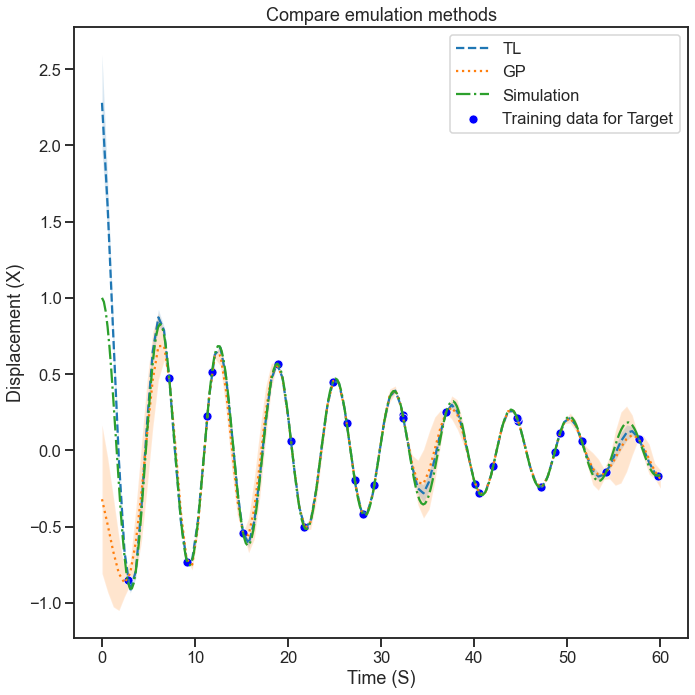

In [8]:
TL_model = make_tl_emulator(30)

In [9]:
### Let's explore the Discrepancy function

In [10]:
param_values = np.linspace(0,60,100).reshape(-1,1)
X_train_sb, Y_train_sb = convert_xy_lists_to_arrays([param_values, param_values], [param_values, param_values])
Yt,_ = TL_model.predict(X_train_sb[param_values.shape[0]:,:])
Ys,_ = TL_model.predict(X_train_sb[0:param_values.shape[0],:])

In [11]:
discrp = Yt-Ys*TL_model.gpy_model.multifidelity.scale[0]
discrep2 = Yt-Ys
Y = discrp.flatten()
Y2 = discrep2.flatten()

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning:Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<AxesSubplot:>

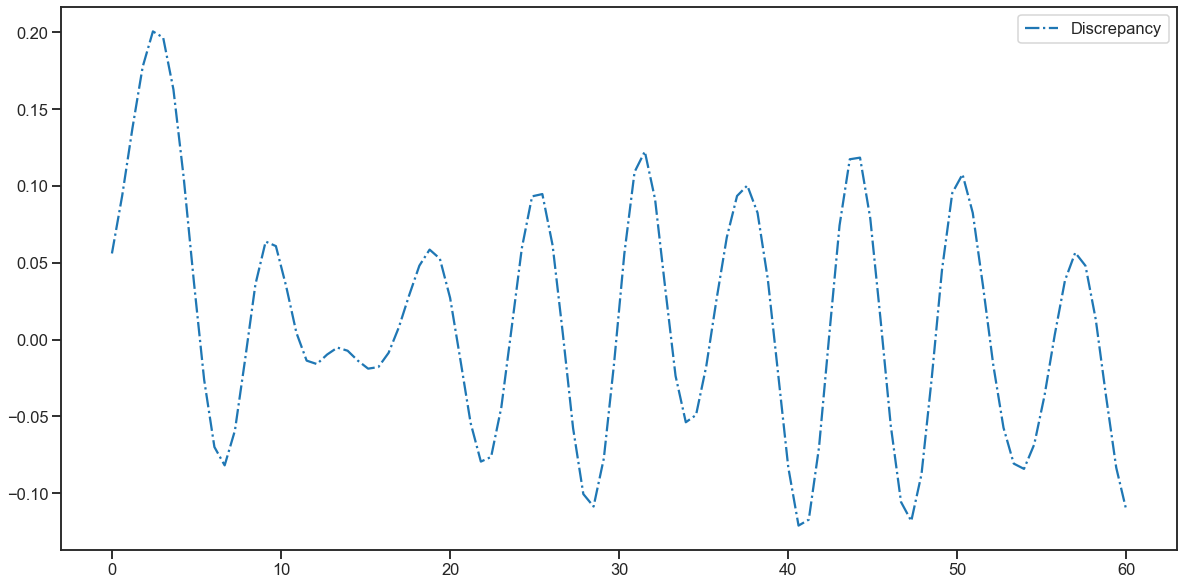

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
sns.lineplot(param_values.flatten(), Y.flatten(), label='Discrepancy', ax=ax, linestyle='dashdot')
#sns.lineplot(param_values.flatten(), Y2.flatten(), label='Discrepancy2', ax=ax, linestyle='dotted')


